In [1]:
import pandas as pd
import seaborn as sns
sns.set()
import numpy as np
import matplotlib.pyplot as plt
import py_pcha

# Get data

In [2]:
# Basic features
def get_basic_features(path):
    features, feature_names = [], []
    for stat in ["BVP", "HR", "EDA", "TEMP"]:
        signal = pd.read_csv(f"{path}/{stat}.csv")[stat]
        features += [signal.min(), signal.max(), signal.mean(), signal.std()]
        feature_names += [f"{stat}_{f}" for f in ["min", "max", "mean", "std"]]
    return feature_names, features

metadata = pd.read_csv("metadata.csv")
basic_ds = []
for path in metadata['Path']:
    feature_names, features = get_basic_features(path)
    basic_ds.append(features)
    
basic_ds = pd.DataFrame(basic_ds, columns = feature_names)

# Archetypal Analysis - Basic features

Variance explained: 0.9801400072417967


<Figure size 1000x1000 with 0 Axes>

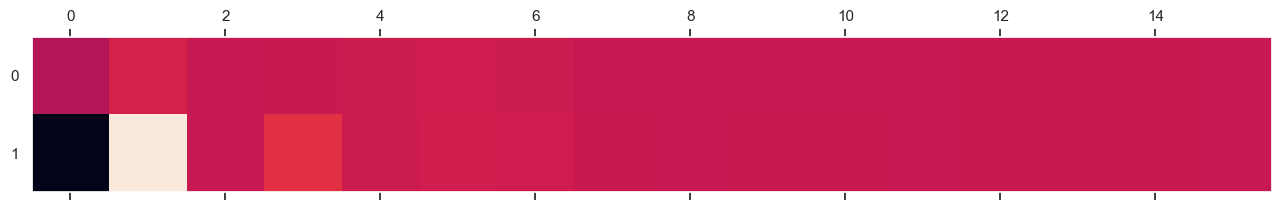

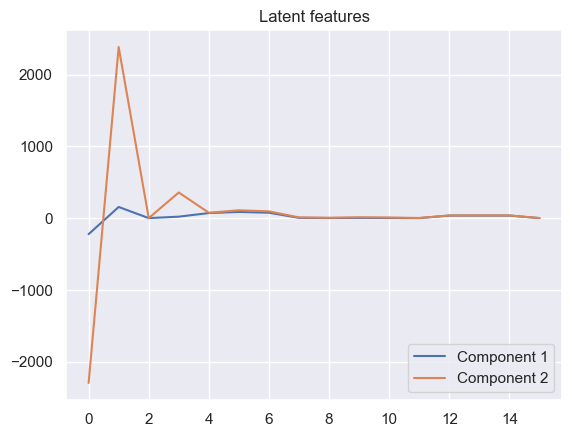

In [188]:
X = basic_ds
n_components = 2

# Does not require that you center data
XC, S, C, SSE, varexpl = py_pcha.PCHA(np.asarray(X.T), noc=n_components, delta=0.1)
S = np.asarray(S)
C = np.asarray(C)

'''
    Output
    ------
    XC : numpy.2darray
        I x noc feature matrix (i.e. XC=X[:,I]*C forming the archetypes)

    S : numpy.2darray
        noc X n matrix, S>=0 |S_j|_1=1

    C : numpy.2darray
        x x noc matrix, C>=0 |c_j|_1=1

    SSE : float
        Sum of Squared Errors
'''

X_hat = X.T @ C @ S
L = 0.5*np.linalg.norm(X.T-X_hat)**2
components = np.asarray(XC.T)

print(f"Variance explained: {varexpl}")

plt.figure(figsize=(10, 10))
plt.matshow(components,aspect='auto')
plt.grid(False)
plt.show()

plt.figure()
plt.title("Latent features")
for i in range(components.shape[0]):
    plt.plot(components[i, :], label=f"Component {i+1}")
plt.legend(loc='lower right')
plt.show()

# Archetypal Analysis - Raw data

## Get raw signals

In [129]:
def get_standardized_signals(stat, n=None, last = True):
    if not n:
        n = metadata[['EDA_n', 'BVP_n', 'HR_n', 'TEMP_n']].min()[stat+'_n']

    raw_ds, raw_ds_ph1, raw_ds_ph2, raw_ds_ph3 = [], {}, {}, {}
    for path in metadata['Path']:
        
        signal = pd.read_csv(f"{path}/{stat}.csv")[stat]
        if last:
            signal = signal.values[-n:]
        else:
            signal = signal.values[:n]
        
        raw_ds.append(signal)
        if path.endswith("phase1"): raw_ds_ph1[path] = signal 
        elif path.endswith("phase2"): raw_ds_ph2[path] = signal 
        elif path.endswith("phase3"): raw_ds_ph3[path] = signal 
    
    raw_ds = pd.DataFrame(raw_ds, index=metadata['Path'])
    raw_ds_ph1 = pd.DataFrame(raw_ds_ph1.values(), index=raw_ds_ph1.keys())
    raw_ds_ph2 = pd.DataFrame(raw_ds_ph2.values(), index=raw_ds_ph2.keys())
    raw_ds_ph3 = pd.DataFrame(raw_ds_ph3.values(), index=raw_ds_ph3.keys())

    return raw_ds, raw_ds_ph1, raw_ds_ph2, raw_ds_ph3

# Get raw HR signal for each phase and combined
raw_ds, raw_ds_ph1, raw_ds_ph2, raw_ds_ph3 = get_standardized_signals("HR")

## AA on raw HR - All phases

Variance explained: 0.996087013930849


<Figure size 1000x1000 with 0 Axes>

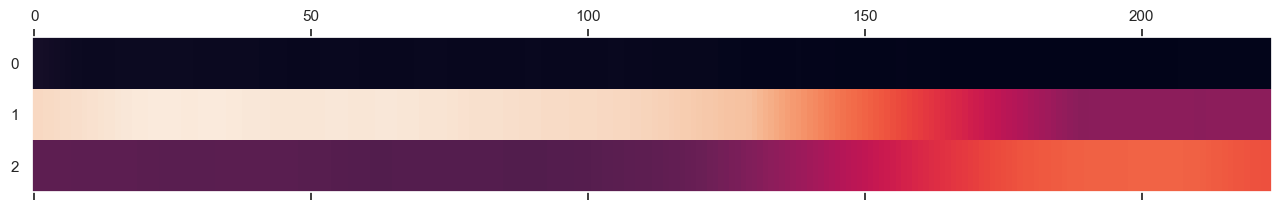

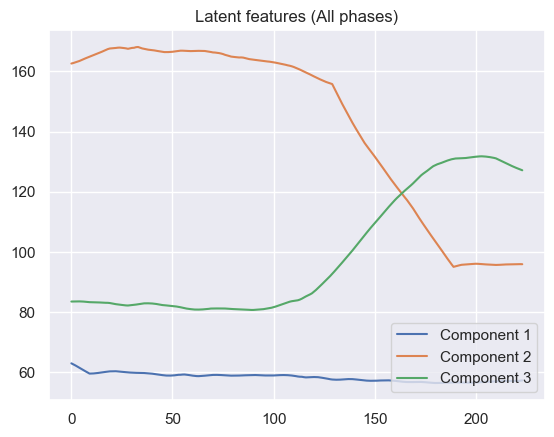

In [160]:
n_components = 3

X = raw_ds
XC, S, C, SSE, varexpl = py_pcha.PCHA(np.asarray(X.T), noc=n_components, delta=0.1)
S = np.asarray(S)
C = np.asarray(C)
X_hat = X.T @ C @ S
L = 0.5*np.linalg.norm(X.T-X_hat)**2
components = np.asarray(XC.T)

print(f"Variance explained: {varexpl}")

plt.figure(figsize=(10, 10))
plt.matshow(components,aspect='auto')
plt.grid(False)
plt.show()

plt.figure()
plt.title("Latent features (All phases)")
for i in range(components.shape[0]):
    plt.plot(components[i, :], label=f"Component {i+1}")
plt.legend(loc='lower right')
plt.show()

## AA on raw HR - For each phase

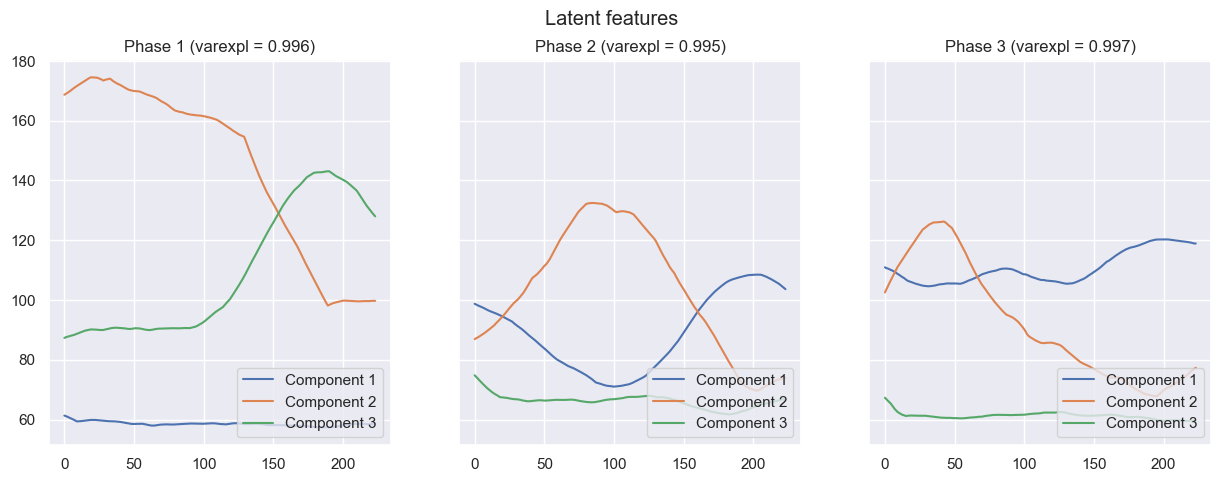

In [159]:
n_components = 3

phase_data = [raw_ds_ph1, raw_ds_ph2, raw_ds_ph3]
fig, ax = plt.subplots(1, 3, figsize=(15,5),sharex=False, sharey=True)
fig.suptitle("Latent features")
for phase in range(len(phase_data)):
    X = phase_data[phase]
    
    # AA
    XC, S, C, SSE, varexpl = py_pcha.PCHA(np.asarray(X.T), noc=n_components, delta=0.1)
    S = np.asarray(S)
    C = np.asarray(C)
    X_hat = X.T @ C @ S
    L = 0.5*np.linalg.norm(X.T-X_hat)**2
    components = np.asarray(XC.T)

    # Plot
    ax[phase].set_title(f"Phase {phase+1} (varexpl = {round(varexpl, 3)})")
    for i in range(components.shape[0]):
        ax[phase].plot(components[i, :], label=f"Component {i+1}")
    ax[phase].legend(loc='lower right')

## AA on raw HR - Different number of components (All phases)

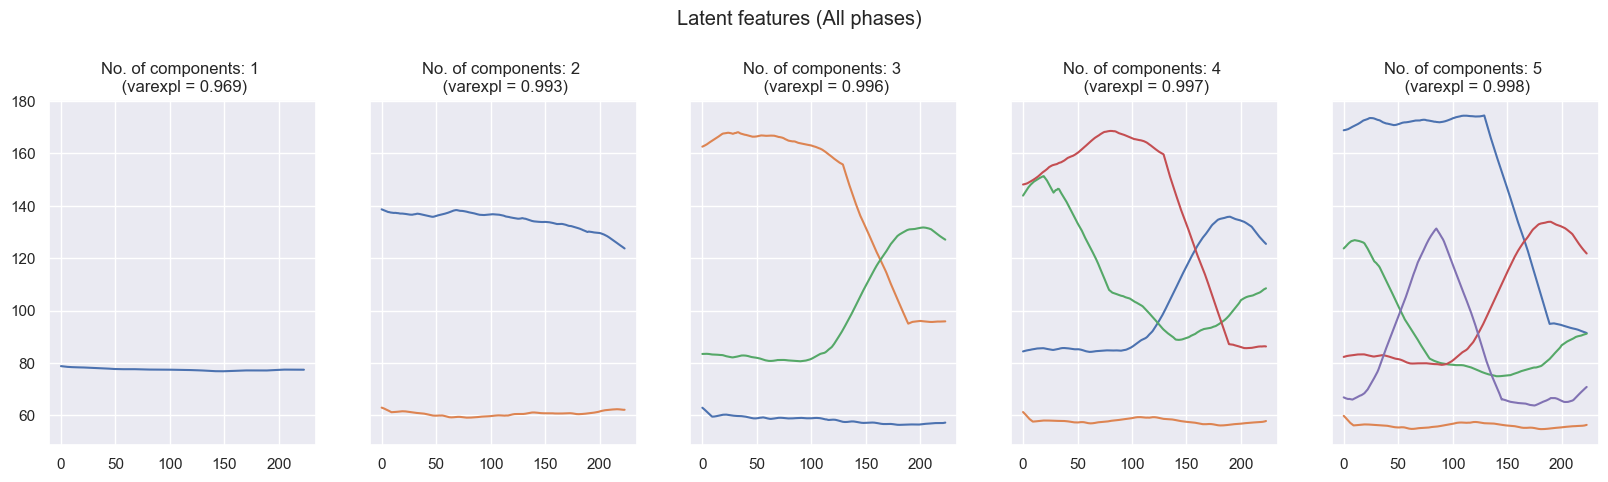

In [185]:
n_components_list = range(1,6)

fig, ax = plt.subplots(1, len(n_components_list), figsize=(20,5),sharex=False, sharey=True)
fig.suptitle("Latent features (All phases)")
fig.subplots_adjust(top=0.8)
X = raw_ds

for j, n_components in enumerate(n_components_list):

    # AA
    XC, S, C, SSE, varexpl = py_pcha.PCHA(np.asarray(X.T), noc=n_components, delta=0.1)
    S = np.asarray(S)
    C = np.asarray(C)
    X_hat = X.T @ C @ S
    L = 0.5*np.linalg.norm(X.T-X_hat)**2
    components = np.asarray(XC.T)

    # Plot
    ax[j].set_title(f"No. of components: {n_components} \n (varexpl = {round(varexpl, 3)})")
    for i in range(components.shape[0]):
        ax[j].plot(components[i, :], label=f"Component {i+1}")
    #ax[j].legend(loc='lower right')

